In [2]:
import os
import pandas as pd
from src.utils import prep

pd.set_eng_float_format(accuracy=2, use_eng_prefix=True)

df = prep.load_dataset(prep.INPUTDIR, prep.LOTTI_FNAME, prep.VINCITORI_FNAME)
df = prep.split_sum_totals(df)
df = prep.feature_extraction(df)

In [27]:
agent = "id_pa"
N = 25
min_lot = df.groupby([agent, df.data_inizio.dt.year]).size().unstack().min(axis=1).rename("min_nlots")
t = df.join(min_lot, on=agent) 
t = t[t["min_nlots"] > N]
t.groupby("id_scelta_contraente").size().sort_values(ascending=False)

id_scelta_contraente
23    531301
8      65101
4      29297
26     23414
14      9857
1       5307
2       3116
6       3105
7       2048
3       2035
22      2023
17      1984
27      1210
24       704
29       698
21       393
25       162
31       153
5        150
30        83
33        13
38         1
dtype: int64

In [66]:
df["year"] = df["data_inizio"].dt.year
df.groupby("year").size()

year
2016    241026
2017    248554
2018    266080
dtype: int64

In [68]:
train_mask = (df["year"] == 2016) | (df["year"] == 2017)
test_mask = df["year"] == 2018

0          True
1          True
2          True
3          True
4         False
          ...  
755752     True
755753     True
755754    False
755755     True
755756     True
Name: year, Length: 755660, dtype: bool

In [78]:
min_yearly_n_contr = 5
revenue_mask = (df.importo > df.pa_med_ann_expenditure) & \
    (df.importo > df.be_med_ann_revenue)
# consider outliers only the 
min_year_contr_mask = (df.be_med_ann_n_contr > min_yearly_n_contr) & \
    (df.pa_med_ann_n_contr > min_yearly_n_contr)
df["outlier"] = revenue_mask & min_year_contr_mask


In [82]:
n_years = 10
years_mask = (df.id_scelta_contraente == 23) & \
    (df.duration > n_years * 365)
df["outlier"] = df["outlier"] | years_mask

In [58]:
df["outlier"] = ~(revenue_mask & min_year_contr_mask)

In [62]:
df.groupby("id_scelta_contraente").size()

id_scelta_contraente
1       6021
2       3674
3       2320
4      32593
5        217
6       3532
7       2355
8      72147
14     10048
17      2485
21       527
22      2371
23    588035
24       791
25       182
26     25997
27      1353
29       755
30        88
31       155
33        13
38         1
dtype: int64

In [61]:
df[df["id_scelta_contraente"] == 1].groupby("outlier").size()

outlier
False      19
True     6002
dtype: int64

In [41]:
# outliers.groupby(["id_scelta_contraente", "cpv"]).size().sort_values(ascending=False)

id_scelta_contraente  cpv
1                     90     5
                      50     3
                      45     3
4                     45     3
1                     33     2
26                    33     2
4                     85     2
23                    50     2
2                     33     2
1                     55     2
8                     85     1
23                    80     1
26                    45     1
                      85     1
23                    39     1
                      30     1
26                    90     1
23                    18     1
4                     71     1
8                     45     1
6                     45     1
4                     60     1
                      50     1
                      42     1
3                     85     1
1                     92     1
                      85     1
                      66     1
                      60     1
27                    33     1
dtype: int64

for each award procedure, plot outliers

In [43]:
df.columns

Index(['id_lotto', 'id_pa', 'oggetto', 'id_scelta_contraente', 'importo',
       'data_inizio', 'data_fine', 'id_lsf', 'cpv', 'id_be',
       'pa_med_ann_expenditure', 'be_med_ann_revenue', 'pa_med_ann_contr',
       'be_med_ann_contr', 'pa_med_ann_n_contr', 'be_med_ann_n_contr',
       'duration', 'sinMonth', 'cosMonth', 'daysSinceBaseDate', 'outlier'],
      dtype='object')

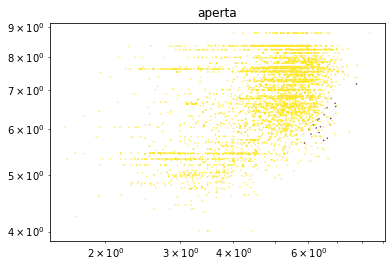

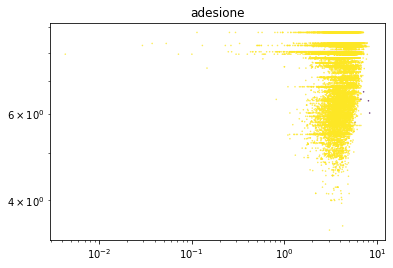

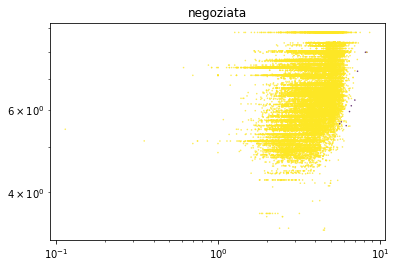

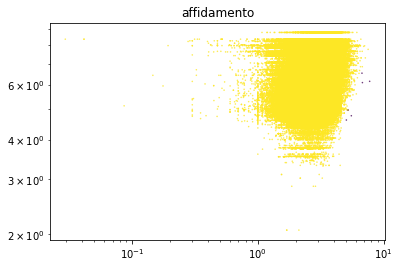

In [47]:
import matplotlib.pyplot as plt
import numpy as np
for id, proc in prep.abc_procedure_short_names.items():
    plt.figure()
    table = df[df["id_scelta_contraente"] == id]
    x = np.log10(table["importo"])
    y = np.log10(table["pa_med_ann_expenditure"])
    plt.scatter(x, y, c=table["outlier"], s=.3, alpha=.8)
    plt.title(proc)
    plt.xscale("log")
    plt.yscale("log")
    plt.show()
    